**Importing Esstential Libraries**

In [3]:
# initiating gpu using tensorflow.
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [4]:
import numpy as np
import pandas as pd
import glob
import random 
import os
import cv2

from google.colab import files
import os
import zipfile

#visulaziation
import matplotlib.pyplot as plt


# image
from PIL import Image

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet101V2, Xception, ResNet50
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#setting seed to reproduce the same result every time the code is re-run
seed_num = 1
tf.random.set_seed(seed_num)
np.random.seed(seed_num)

**Mounting the google drive for getting the data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Unzipping the birds datafile**

In [6]:
%%capture
!unzip /content/drive/MyDrive/birds 

**Bird Classfication**

**overview of images from the birds dataset:**

**Setting Directory**

In [7]:
train_dir="train"
test_dir="test"
valid_dir="valid"

In [8]:
train_datagen=ImageDataGenerator(rescale=1/255)
val_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [9]:
train_generator=train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',seed=seed_num,
                                                 class_mode='sparse',batch_size=64)

val_generator=val_datagen.flow_from_directory(valid_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',seed=seed_num,
                                                 class_mode='sparse',batch_size=64)

test_generator=test_datagen.flow_from_directory(test_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',seed=seed_num,
                                                 class_mode='sparse',batch_size=64)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


**Overview of images from the birds dataset:**

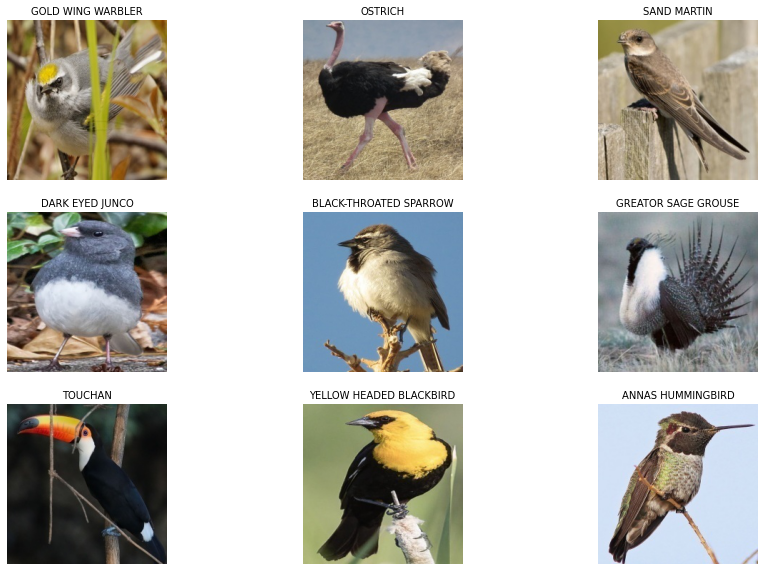

In [10]:
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(train_dir, train_generator)
plt.figure(figsize=(15,10))
for i in range(0,9):
    X = load_img(x[i])
    plt.subplot(3,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=10)
    plt.imshow(X)
plt.show()

**Transfer Learning Using ResNet101V2**

In [11]:
#instantiate a base model with pre-trained weights.
base_model=ResNet101V2(include_top=False, weights="imagenet", input_shape=(224,224,3))

171327488/171317808 [==============================] - 4s 0us/step


In [12]:
#freeze the base model
base_model.trainable = False

In [13]:
#Create new model on top
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              205522944 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [15]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
print("Model compilation completed.")

Model compilation completed.


This callback will stop the training when there is no improvement in the validation accuracy for Four consecutive epochs.

In [16]:
callbacks = [EarlyStopping(monitor='val_accuracy',patience=3)]

In [17]:
history=model.fit(train_generator,validation_data=val_generator,epochs=10,callbacks=callbacks)

Epoch 1/10
551/551 [==============================] - 216s 361ms/step - loss: 1.8482 - accuracy: 0.5763 - val_loss: 0.3147 - val_accuracy: 0.9112
Epoch 2/10
551/551 [==============================] - 204s 371ms/step - loss: 0.4394 - accuracy: 0.8787 - val_loss: 0.2301 - val_accuracy: 0.9320
Epoch 3/10
551/551 [==============================] - 204s 370ms/step - loss: 0.2117 - accuracy: 0.9391 - val_loss: 0.2445 - val_accuracy: 0.9304
Epoch 4/10
551/551 [==============================] - 203s 369ms/step - loss: 0.1411 - accuracy: 0.9593 - val_loss: 0.2517 - val_accuracy: 0.9272
Epoch 5/10
551/551 [==============================] - 203s 369ms/step - loss: 0.1217 - accuracy: 0.9632 - val_loss: 0.2619 - val_accuracy: 0.9304


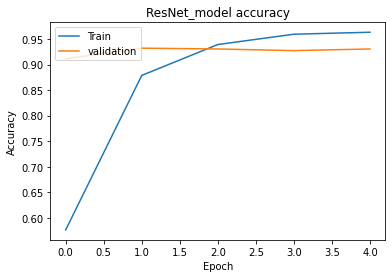

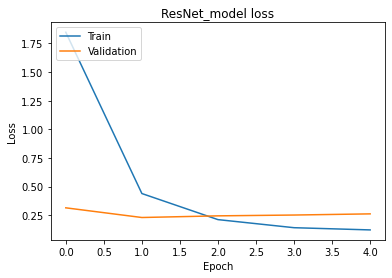

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet_model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Test accuracy**

In [19]:
model.evaluate(test_generator)

20/20 [==============================] - 6s 284ms/step - loss: 0.1639 - accuracy: 0.9632


[0.1638641655445099, 0.9631999731063843]

**Accuracy, Precision and Recall values**

In [20]:
import math
seed=seed_num
n=len(test_generator.filenames)
n1=math.ceil(n/(1.0*64))
test_label=[]
for i in range(0,int(n1)):
  test_label.extend(np.array(test_generator[i][1]))

In [21]:
yhat_prob=model.predict(test_generator)

In [22]:
yhat_classes=np.argmax(yhat_prob,axis=1)
print(yhat_classes)


[236 242 119 ...  13 102  69]


In [23]:
accuracy_ResNet=accuracy_score(test_label,yhat_classes)
print("Accuracy for the model: %f" % accuracy_ResNet)
precision_ResNet=precision_score(test_label,yhat_classes,average='weighted')
print("Precision for the model: %f" % precision_ResNet)
recall_ResNet=recall_score(test_label,yhat_classes,average='weighted')
print("Recall for the model: %f" % recall_ResNet)

Accuracy for the model: 0.963200
Precision for the model: 0.970029
Recall for the model: 0.963200


**Confusion Matrix**

In [24]:
confusion_ResNet=confusion_matrix(test_label,yhat_classes)
confusion_ResNet

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 3]])

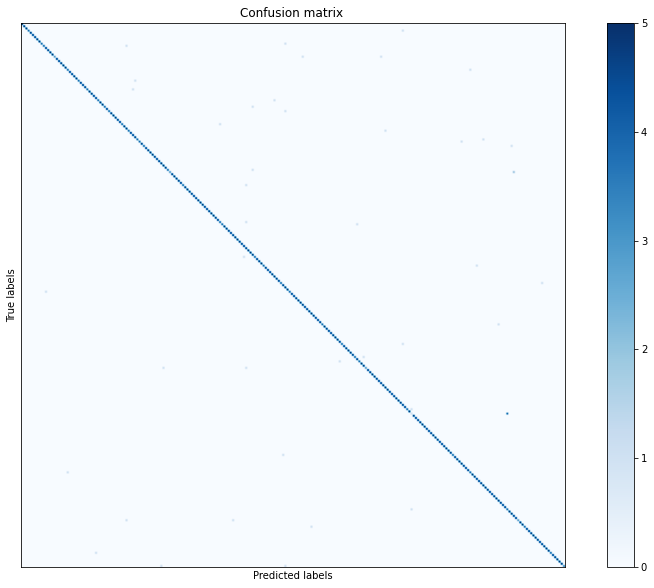

In [25]:
plt.figure(figsize=(15,10))
plt.imshow(confusion_ResNet, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**Saving the model**

The saved full model file includes:

The model's architecture,The model's weight values

In [26]:
model.save('content/ResNet101V2.h5')
print("saved the model")

saved the model


**Reloading with the load_model function:**

In [27]:
model_loaded = load_model("content/ResNet101V2.h5")

**Prediction**

In [28]:
dirs = test_generator.class_indices
rdirs = {v:k  for k,v in dirs.items()}

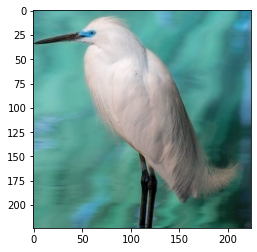

predict: SNOWY EGRET actual: SNOWY EGRET


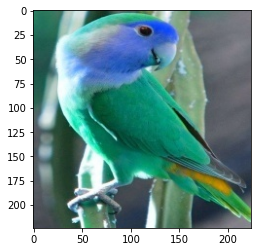

predict: ROSY FACED LOVEBIRD actual: ROSY FACED LOVEBIRD


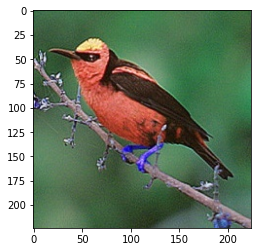

predict: CARMINE BEE-EATER actual: RED HONEY CREEPER


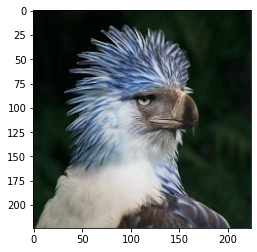

predict: PHILIPPINE EAGLE actual: PHILIPPINE EAGLE


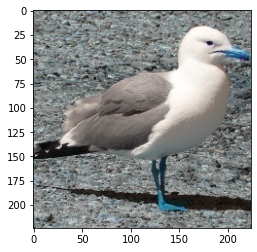

predict: CALIFORNIA GULL actual: CALIFORNIA GULL


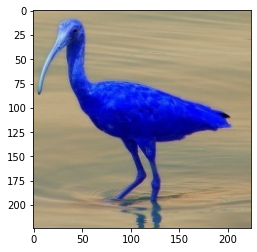

predict: SCARLET IBIS actual: SCARLET IBIS


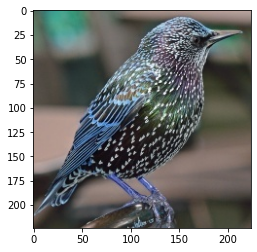

predict: COMMON STARLING actual: COMMON STARLING


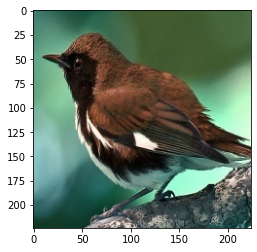

predict: BLACK THROATED WARBLER actual: BLACK THROATED WARBLER


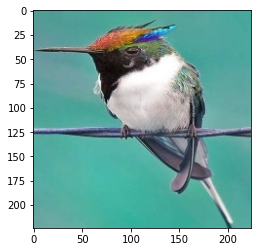

predict: HORNED SUNGEM actual: HORNED SUNGEM


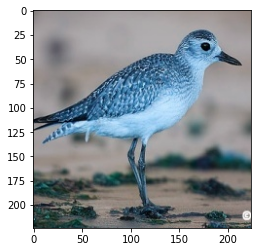

predict: GREY PLOVER actual: GREY PLOVER


In [29]:
for i in range(10):
    choice = random.randint(0,249)
    dir = rdirs[choice]
    files = os.listdir(test_dir+'/'+dir)
    img = random.choice(files)
    a = cv2.imread(test_dir+'/'+dir+'/'+img)  
    a = cv2.resize(a,(224,224))
    plt.imshow(a)
    plt.show()
    a = np.array(a/255)
    answer = model_loaded.predict(np.array([a]))
    pred = np.argmax(answer)
    print("predict:",rdirs[pred],"actual:",rdirs[choice])

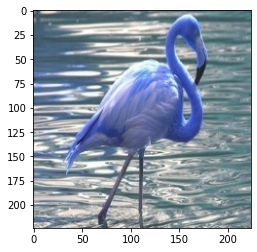

predict: FLAMINGO


In [32]:
image1= cv2.imread("/5.jpg")  
image1 = cv2.resize(image1,(224,224))
plt.imshow(image1)
plt.show()
image1 = np.array(image1/255)
answer = model_loaded.predict(np.array([image1]))
pred = np.argmax(answer)
pred
print("predict:",rdirs[pred])